In [23]:
import dt_apriltags as apriltag
import cv2
import annotation_utils as utils
# # import glob
import numpy as np
from scipy.spatial.transform import Rotation as R
# # from pathlib import Path
# # import re
import pyrealsense2 as rs
import urx
# import matplotlib.pyplot as plt
# import seaborn as sns
# import json
# import pickle as pkl
# from tqdm import tqdm
# from skimage.transform import ProjectiveTransform, warp

In [2]:
dist = np.array([[-0.04797802,  0.04744357,  0.00017416,  0.00067967, -0.00408397]])
detector = apriltag.Detector(families="tagStandard52h13")
mtx = np.array([[633.09029639, 0., 629.06462963], [0., 638.7544391, 362.74013262], [0., 0., 1.]])

camera_params = [633.0902963939839, 638.754439101168, 629.0646296262861, 362.7401326185789]

In [5]:
cv2.destroyAllWindows()

In [4]:
def draw_corners(img, r, show=False):
    if isinstance(r, np.ndarray):
        imagePoints = [r]
    else:
        imagePoints = r.corners.reshape(1,4,2)
    
    for corner in range(np.size(imagePoints[0],axis=0)):
        center = ((int(imagePoints[0][corner][0]),int(imagePoints[0][corner][1])))
        cv2.circle(img, center, 3, (0,0,255), -1)
    
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(0)
    return imagePoints[0]

In [20]:
anchor_gt_2D = np.array(
[(623, 335),
 (610, 318),
 (636, 318),
 (597, 336),
 (649, 336),
 (610, 358),
 (636, 358)], dtype=float)

img_with_marker_name = 'marker_close_new_4.jpg'
img_without_marker_name = 'no_marker_close_new_4.jpg'

anchors = np.zeros((7,3), dtype=float)

anchors[0] = [0.0, 0.0, 2.25]
anchors[1] = [8.0, 11.2, 2.25]
anchors[2] = anchors[1].copy()
anchors[2][0] *= -1
anchors[3] = [16.0, 0, 2.25]
anchors[4] = anchors[3].copy()
anchors[4][0] *= -1
anchors[5] = [8.0, -13.86, 2.25]
anchors[6] = anchors[5].copy()
anchors[6][0] *= -1

def solve_pnp(obj_points, imagePoints,mtx, dist):
    success, rvec, tvec = cv2.solvePnP(obj_points, np.array([imagePoints]), mtx, dist)
        
    if not success:
        print('not success in PnP')
        return
    return tvec, rvec

In [31]:
# print(solve_pnp(anchors,anchor_gt_2D,mtx, dist))

img_with_marker_name = 'marker_close_new_4.jpg'
# img_without_marker_name = 'no_marker_close_new_4.jpg'

img = cv2.imread(img_with_marker_name)

res = utils.detect_apriltag(img, camera_params)

corners_2d = res[0].corners
center_2d = res[0].center

marker_pts_2d = np.vstack((center_2d, corners_2d))
corners_3D = np.array(
[(0, 0,0),
 (24, 24,0),
 (24, -24,0),
 (-24, -24,0),
 (-24,24, 0)], dtype=float)
print(marker_pts_2d)
print(corners_3D)

[[622.32806907 338.88037845]
 [583.66021729 300.01373291]
 [582.85675049 377.90563965]
 [660.92974854 377.68051147]
 [661.30029297 300.34857178]]
[[  0.   0.   0.]
 [ 24.  24.   0.]
 [ 24. -24.   0.]
 [-24. -24.   0.]
 [-24.  24.   0.]]


In [37]:
tvec_gt,rvec_gt = solve_pnp(anchors,anchor_gt_2D,mtx, dist)
tvec_m,rvec_m = solve_pnp(corners_3D,marker_pts_2d,mtx, dist)

rot_error = R.from_rotvec(rvec_gt.flatten()).as_matrix() @ R.from_rotvec(rvec_m.flatten()).as_matrix()


print(R.from_matrix(rot_error).as_rotvec())

[-5.3892679  -0.78869068  0.20138901]


(3, 1)

In [12]:
obj_points = np.zeros((5,3), dtype=float)
obj_points[0][1] = 40.0
obj_points[1][0] = 40.0
obj_points[1][1] = 40.0
obj_points[2][0] = 40.0
obj_points[4][0] = 20.0
obj_points[4][1] = 20.0

print(obj_points.shape)

for r in results:
    imagePoints = r.corners.reshape(1,4,2)
    center = r.center.reshape(1,1,2)

    imgpoints = np.concatenate((imagePoints, center), axis=1)
    success, rvec, tvec = cv2.solvePnP(obj_points, imgpoints, mtx, dist)


(5, 3)


NameError: name 'results' is not defined

In [7]:
def draw_apriltag(img, results, show=False):
    if not results: return
    if isinstance(img, str):
        img = cv2.imread(img)
    
    for r in results:
        (ptA, ptB, ptC, ptD) = r.corners
        ptA = int(ptA[0]), int(ptA[1])
#         ptB = int(ptB[0]), int(ptB[1])
#         ptC = int(ptC[0]), int(ptC[1])
#         ptD = int(ptD[0]), int(ptD[1])

#     # draw bbox
#         cv2.line(img, ptA, ptB, (0, 255, 0), 2)
#         cv2.line(img, ptB, ptC, (0, 255, 0), 2)
#         cv2.line(img, ptC, ptD, (0, 255, 0), 2)
#         cv2.line(img, ptD, ptA, (0, 255, 0), 2)
        draw_corners(img, r)
#     ptA = int(r.corners[0][0]), int(r.corners[0][1])
    
    # draw center
    cX, cY = int(r.center[0]), int(r.center[1])
    cv2.circle(img, (cX, cY), 5, (0, 0, 255), -1)
    
    # draw the tag family on the image
    tagFamily = r.tag_family.decode("utf-8")
    cv2.putText(img, tagFamily, (ptA[0], ptA[1] - 15),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
#     print("{}. [INFO] tag family: {} --- tag id: {}".format((i+1), 

    if show:
        cv2.imshow("Image", img)
        cv2.waitKey(10)

In [2]:
obj_points = np.zeros((5,3), dtype=float)
obj_points[0][1] = 40.0
obj_points[1][0] = 40.0
obj_points[1][1] = 40.0
obj_points[2][0] = 40.0
obj_points[4][0] = 20.0
obj_points[4][1] = 20.0

print(obj_points)

[[ 0. 40.  0.]
 [40. 40.  0.]
 [40.  0.  0.]
 [ 0.  0.  0.]
 [20. 20.  0.]]


In [12]:
def draw_points(img, points, show=False, raw=False):
    for i in range(len(points)):
        if raw:
            point = (int(points[i][0]), int(points[i][1]))
        else:
            point = (int(points[i][0][0]), int(points[i][0][1]))
        cv2.circle(img, point, 2, (255,0,255), -1)
    
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(10)
    

In [7]:
def draw_nums(img, points, show=False):
    for i in range(len(points)):
        point = (int(points[i][0][0]), int(points[i][0][1]))
        cv2.putText(img, str(i), point, cv2.FONT_HERSHEY_SIMPLEX, 12, (255,0,255))
        cv2.circle(img, point, 2, (255,0,255), -1)
    
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(10)

In [14]:
def get_socket_points(img, points_array, lines_array, bbox_array, tvec, rvec, 
                      show=False, draw_l=True, draw_p=True, draw_b=True):
    if isinstance(img, str):
        img = cv2.imread(img)
#     img = increase_brightness(img, 50)
    img_points = None
    
    if draw_p:
        img_points, _ = cv2.projectPoints(points_array, rvec, tvec, mtx, dist)
        draw_points(img, img_points)
    if draw_l:
        lines_points, _ = cv2.projectPoints(lines_array, rvec, tvec, mtx, dist)
        draw_lines(img, lines_points)
    if draw_b:
        bbox_arr, _ = cv2.projectPoints(bbox_array, rvec, tvec, mtx, dist)
        draw_bbox(img, bbox_arr)
    
    if show:
        cv2.imshow("Image", img)
        cv2.waitKey(1)
    return img, img_points

In [ ]:
def detect_apriltag(img):
    if isinstance(img, str):
        print('reading img from file system')
        img = cv2.imread(img)
    if not type(img[0][0][0]) == np.uint8:
        img = img/img.max()
        img *= 255
        img = img.astype(np.uint8)
#         cv2.imshow('detect_apriltag', img)
        cv2.waitKey(1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    results = detector.detect(gray,
                              estimate_tag_pose=True,
                              camera_params=camera_params, 
                              tag_size=0.04)
    if not results:
        print('apriltag not found')
        return
    return results

In [8]:
def warp_img(image, res):
    corners = res[0].corners
    
    corners[:2] = np.array(sorted(corners[:2], key=lambda x: x[1]))
    corners[2:] = np.array(sorted(corners[2:], key=lambda x: x[1]))

    a = corners[:2][:, 0].mean()
    c = corners[2:][:, 0].mean()
    b = corners[::2][:, 1].mean()
    d = corners[1::2][:, 1].mean()

    desired_corners = np.array([[a, b], [a, d], [c, b], [c, d]], dtype=int)

    tform = get_projection(desired_corners, corners)
    image_warped = warp(image, tform)
    return image_warped, desired_corners

In [9]:
def get_projection(c_to, c_from):
    tform = ProjectiveTransform()
    tform.estimate(c_to, c_from)
    return tform

In [15]:
# pose_left = ur10.getl()

In [ ]:
ur10.movej((-4.048973385487692, -1.1045106093036097, 1.546417236328125,
            2.811586380004883, -0.7216728369342249, 3.1041338443756104))

In [ ]:
# pose_center = ur10.getl()

In [ ]:
# pose_right = ur10.getl()

In [10]:
points_arr = np.array(
    [[-132. ,   44. ,  -46. ],
       [-132. ,   27. ,  -46. ],
       [-143. ,   46. ,  -43. ],
       [-143. ,   40. ,  -45. ],
       [-142.5,   31. ,  -46. ],
       [-142.5,   24. ,  -45. ],
       [-149. ,   60. ,  -45. ],
       [-149. ,   43. ,  -44. ],
       [-149. ,   27. ,  -45. ],
       [-149. ,   11. ,  -45. ],
       [-156. ,   47. ,  -46. ],
       [-156. ,   39. ,  -45. ],
       [-156. ,   31. ,  -46. ],
       [-156. ,   23. ,  -46. ],
       [-162. ,   35. ,  -45. ],
       [-171. ,   44. ,  -46. ],
       [-171. ,   27. ,  -45. ]], dtype=np.float32)
DEPTH = -40
bbox = np.array([
    [10, 128, DEPTH],
    [59, 128, DEPTH],
    [59, 170, DEPTH],
    [10, 170, DEPTH]
], dtype=float)
bbox[:,[0, 1]] = bbox[:,[1, 0]]
bbox[:, 0] = -bbox[:, 0]

In [14]:
lines = np.array([
    [0,0,0],
    [100,0,0],
    [0,100,0],
    [0,0,100]
], dtype=float)

In [19]:
def draw_bbox(img, bbox_arr, show=False):
    print(bbox_arr)
    color = (0,255,0)
    cv2.line(img, 
            [int(x) for x in bbox_arr[0][0]],
            [int(x) for x in bbox_arr[1][0]], color, 1)
    cv2.line(img, 
            [int(x) for x in bbox_arr[1][0]], 
            [int(x) for x in bbox_arr[2][0]], color, 1)
    cv2.line(img, 
            [int(x) for x in bbox_arr[2][0]], 
            [int(x) for x in bbox_arr[3][0]], color, 1)
    cv2.line(img, 
            [int(x) for x in bbox_arr[3][0]], 
            [int(x) for x in bbox_arr[0][0]], color, 1)
    
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(10)

In [11]:
def draw_lines(img, line_arr, show=False):
    colors = [(255,255,0), (0,255,0), (0,0,255)]
    for i, line in enumerate(line_arr[1:]):
        cv2.line(img, [int(x) for x in line_arr[0][0]], [int(x) for x in line[0]], colors[i-1], 2)
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(10)

In [30]:
cv2.destroyAllWindows()

In [34]:
name = 2
count = 0
centers = []
# ress = []
while count < 10:
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    count += 1
    
    if not res: 
        continue

#     ress = res
#     break
#     centers.append(res[0].center)
#     print(res)
#     ress.append(res)
    
    draw_apriltag(img, res,show=True)
    tvec, rvec,objpts = solve_pnp(res)
    print(tvec)
#     processed, _ = get_socket_points(img, points_arr, lines, bbox, tvec, rvec, 
#                                    show=True, draw_l=True, draw_p=True, draw_b=False)
    
    
#     fname = f'/home/viacheslav/jupyter_notebooks/{name}_processed.jpg'
#     cv2.imwrite(fname, img)
#     name += 1
#     break


[[-23.70179131]
 [  7.87241964]
 [120.50352939]]
[[-23.70309857]
 [  7.87159956]
 [120.57752586]]
[[-23.69677832]
 [  7.8761461 ]
 [120.47788855]]
[[-23.69792147]
 [  7.86495644]
 [120.45759948]]
[[-23.69339594]
 [  7.88384789]
 [120.48978196]]
[[-23.69707954]
 [  7.86952662]
 [120.49443224]]
[[-23.70581052]
 [  7.87466282]
 [120.47124536]]
[[-23.69179754]
 [  7.86186315]
 [120.42158973]]
[[-23.69822029]
 [  7.87394518]
 [120.47162631]]
[[-23.71271779]
 [  7.8633447 ]
 [120.52663715]]


In [ ]:
[[-23.50502963]
 [  8.35980833]
 [110.64977061]]

In [ ]:
centers = np.array(centers)

print(np.var(centers,axis = 0))

In [24]:
name = 1
ress1 = []
centers = []
corners = []
count = 0
while name< 100:
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
#     print(res)
    if not res: 
        continue
    for r in res:
        centers.append(r.center)
        corners.append(r.corners)
    count+=1
#     ress.append(res)
#     cv2.imshow("Image", img)
#     cv2.waitKey(10)
    draw_apriltag(img, res)
#     tvec, rvec, objpts = solve_pnp(res)
#     processed, _ = get_socket_points(img, points_arr, lines, bbox, tvec, rvec, 
#                                    show=True, draw_l=True, draw_p=False, draw_b=False)
    
    
    fname = f'/home/viacheslav/jupyter_notebooks/new_data/{name}_processed.jpg'
#     print(fname)
    cv2.imwrite(fname, img)
    name += 1
#     break


Error, more than one new minimum found.


In [161]:
centers = np.array(centers)
print(np.mean(centers,axis = 0))
print(np.sqrt(np.var(centers,axis = 0)))

[653.14998719 323.76294511]
[0.01481017 0.01045825]


In [162]:
corners = np.array(corners)
# i = 0
for i in range (4):
# print(np.mean(corners[:,i],axis = 0))
    print(np.sqrt(np.var(corners[:,i],axis = 0)))
# print(corners[0])

[0.01653605 0.02842677]
[0.03333079 0.01224933]
[0.00483051 0.00614852]
[0.00464149 0.02144295]


In [ ]:
corners[:10,0]

In [ ]:
# Good lighting 
print(np.mean(centers,axis = 0))
print(np.var(centers,axis = 0))

[655.96844896 321.05286757]
[0.00012992 0.00013354]

# Poor lighting 
[656.07557452 321.20941614]
[0.00089831 0.00115515]



In [ ]:
centers

In [ ]:
ress1[0][0]

In [ ]:
ress[0][0].center

In [ ]:
results = np.array([r[0].center for r in ress])
results[:,1].std()

In [16]:
def make_photo(path='/home/viacheslav/jupyter_notebooks/processed_23_9', name=0):
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    if not res: 
        return name
    draw_apriltag(img, res)
    tvec, rvec = solve_pnp(res)
    processed = get_socket_points(img, points_arr, lines, bbox, tvec, rvec, draw_b=False, draw_l=False)
    cv2.imshow('img', img)
    cv2.waitKey(1)
    fname = path+f'/{name}_processed.jpg'
    cv2.imwrite(fname, processed)
    name += 1
    return name

In [17]:
def move_to_next_pos_and_photo(end:list, num_photos:int, img_name):
    start = ur10.getl()
    deltas = np.array([x-y for x, y in zip(end, start)])/num_photos
    for _ in range(num_photos):
        ur10.movel(ur10.getl()+deltas, vel=0.1, acc=0.5)
        img_name = make_photo(name=img_name)
    return img_name

In [33]:
cv2.destroyAllWindows()

In [ ]:
ur10.getl()

In [ ]:
boundary_positions = np.array([[ 0.232085  , -0.61961176,  0.43073168,  1.13699011,  1.24920145,
         1.22539067],
       [ 0.2333736 , -0.60270578,  0.63426659,  1.17489684,  1.22881322,
         1.24945387],
       [ 0.42691084, -0.61264868,  0.58616166,  1.3315313 ,  1.41684329,
         1.23695536],
       [ 0.29272549, -0.60669106,  0.33210261,  0.9753124 ,  0.95871666,
         1.43494421],
       [ 0.33165193, -0.25687359,  0.36506057,  1.30079001,  0.75824351,
         0.868352  ],
       [ 0.33153143, -0.22721475,  0.82933533,  1.67432401,  0.98844306,
         0.83238533],
       [ 0.44529088, -0.30760203,  0.6630999 ,  1.49787613,  1.12812965,
         0.9164792 ],
       [ 0.48105068, -0.37105609,  0.34244749,  1.08186592,  0.84939581,
         1.07530735]])

In [ ]:
min_x, max_x = boundary_positions[:, 0].min(), boundary_positions[:, 0].max()
min_y, max_y = boundary_positions[:, 1].min(), boundary_positions[:, 1].max()
min_z, max_z = boundary_positions[:, 2].min(), boundary_positions[:, 2].max()
min_rx, max_rx = boundary_positions[:, 3].min(), boundary_positions[:, 3].max()
min_ry, max_ry = boundary_positions[:, 4].min(), boundary_positions[:, 4].max()
min_rz, max_rz = boundary_positions[:, 5].min(), boundary_positions[:, 5].max()

In [ ]:
img_name = 0

In [ ]:
while True:
    next_pos = [np.random.uniform(min_x, max_x),
                np.random.uniform(min_y, max_y),
                np.random.uniform(min_z, max_z),
                np.random.uniform(min_rx, max_rx),
                np.random.uniform(min_ry, max_ry),
                np.random.uniform(min_rz, max_rz)]
    img_name = move_to_next_pos_and_photo(next_pos, 50, img_name)

In [ ]:
pose_left = [0.4144699791608615,
 -0.28471817373934244,
 0.4506025223319278,
 1.3698459362193829,
 0.8751222887301229,
 0.7944053357672337]

In [ ]:
pose_center = [0.4168558559693215,
 -0.5621571861068889,
 0.4414088449025262,
 1.1886706848218183,
 1.2237760813323468,
 1.1861928832927722]

In [ ]:
pose_right = [0.613646044924774,
 -0.8457833066867604,
 0.39668770616099447,
 0.86630043677316,
 1.6128758106937202,
 1.7491595656007006]

In [7]:
def detect_red_pixels(path:str, img:np.array=None):
    red_pixel =  np.array([237,28, 36])
#     up=220
#     low=40
    if img is None:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    indices = []
    for x, row in enumerate(img):
        for y, cell in enumerate(row):
            if np.array_equal(img[x, y], red_pixel):
#             if img[x, y,0] > up and img[x,y,1] < low and img[x,y,2] < low:
                indices.append((y,x))
#     assert len(indices) == 17, f'wrong keypoint number!! {indices}'
    return indices

In [181]:
cv2.destroyAllWindows()

# Get new keypoints from image

In [5]:
img = cv2.imread('/home/viacheslav/jupyter_notebooks/no_marker.jpg')

In [8]:
px = np.array(detect_red_pixels('/home/viacheslav/jupyter_notebooks/Screenshot_1.png'))
px

array([[237,  84],
       [336,  85],
       [177, 118],
       [397, 119],
       [220, 130],
       [348, 132],
       [185, 147],
       [422, 150],
       [151, 151],
       [435, 181],
       [137, 188],
       [160, 190],
       [132, 215],
       [154, 215],
       [443, 216],
       [130, 246],
       [153, 248],
       [419, 248],
       [442, 248],
       [126, 274],
       [156, 274],
       [415, 277],
       [443, 277],
       [169, 308],
       [125, 309],
       [399, 309],
       [448, 310],
       [125, 339],
       [198, 342],
       [370, 343],
       [449, 345],
       [364, 351],
       [209, 352],
       [182, 371],
       [127, 373],
       [400, 377],
       [449, 377],
       [129, 403],
       [155, 403],
       [419, 404],
       [447, 404]])

In [9]:
cv2.imshow('a', img)
cv2.waitKey(0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to tar

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)



32

In [81]:
cv2.imshow('a', cv2.imread('/home/viacheslav/jupyter_notebooks/marker.jpg'))
cv2.waitKey(0)

32

In [22]:
res = detect_apriltag('/home/viacheslav/jupyter_notebooks/marker.jpg')[0]
res

reading img from file system


Detection object:
tag_family = b'tagStandard52h13'
tag_id = 48701
hamming = 0
decision_margin = 72.51439666748047
homography = [[-7.14084838e-01 -5.31450486e+01  5.96766964e+02]
 [ 5.28093142e+01 -6.98452026e-01  3.53373001e+02]
 [-1.46068232e-05 -4.65591571e-05  1.00000000e+00]]
center = [596.76696399 353.37300145]
corners = [[544.35339355 299.87481689]
 [542.94104004 405.50866699]
 [649.17718506 406.86776733]
 [650.58630371 301.24371338]]
pose_R = [[-0.01281121 -0.99983103 -0.01318278]
 [ 0.99989985 -0.01288915  0.00584447]
 [-0.0060134  -0.01310659  0.99989602]]
pose_t = [[-0.0122298 ]
 [-0.00353095]
 [ 0.24014365]]
pose_err = 1.5760249073091314e-07

In [23]:
draw_corners(img, res, True)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to target thread (0x55e3a88e08c0)

QObject::moveToThread: Current thread (0x55e3a88e08c0) is not the object's thread (0x55e3a8a32f10).
Cannot move to tar

array([[544.35339355, 299.87481689],
       [542.94104004, 405.50866699],
       [649.17718506, 406.86776733],
       [650.58630371, 301.24371338]])

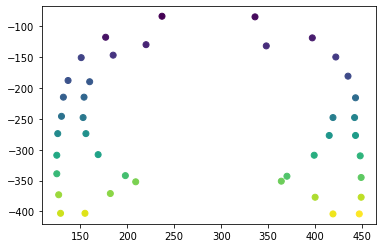

In [24]:
plt.scatter(px[:,0], -px[:,1],c=range(len(px)))

In [25]:
dx = np.array(((res.corners[2] - res.corners[1]) + (res.corners[3] - res.corners[0]))/12).T
dy = np.array(((res.corners[2] - res.corners[3]) + (res.corners[1] - res.corners[0]))/12).T
mat = np.vstack([dx, dy])

In [26]:
mat1 = np.linalg.inv(mat)

In [30]:
marker_points = []
det = np.linalg.det(mat1)
for point in px:
    kp = point.copy()
#     kp[0] -= int(res.center[0])
#     kp[1] -= int(res.center[1])
    p = [kp[0]*mat1[0, 0]+kp[1]*mat1[1, 0], kp[0]*mat1[0,1]+kp[1]*mat1[1,1]]
#     p = np.array([kp[0]*dy[1] - kp[1]*dy[0], -kp[0]*dx[1]+kp[1]*dx[0]])
#     p /= det
    
    marker_points.append(p)
marker_points = np.array(marker_points)

In [31]:
marker_points

array([[13.44653466,  4.59778251],
       [19.03773267,  4.58238536],
       [10.08402894,  6.57249161],
       [22.50799163,  6.4688622 ],
       [12.52125165,  7.22265078],
       [19.75080859,  7.24289992],
       [10.55765314,  8.21365129],
       [23.94309938,  8.21121136],
       [ 8.64071945,  8.4656153 ],
       [24.70057759,  9.96231082],
       [ 7.87805623, 10.57716017],
       [ 9.17835456, 10.67397449],
       [ 7.61607339, 12.11421361],
       [ 8.85839424, 12.09817138],
       [25.17872686, 11.94422772],
       [ 7.52651465, 13.87625095],
       [ 8.82681298, 13.97306527],
       [23.84760145, 13.77910016],
       [25.14639143, 13.76232874],
       [ 7.32175511, 15.46936807],
       [ 9.015829  , 15.4474923 ],
       [23.64359609, 15.42901015],
       [25.22473172, 15.40859276],
       [ 9.77556974, 17.36897037],
       [ 7.29168222, 17.4578477 ],
       [22.76422372, 17.25804905],
       [25.53196524, 17.2791115 ],
       [ 7.31430756, 19.16163379],
       [11.43881655,

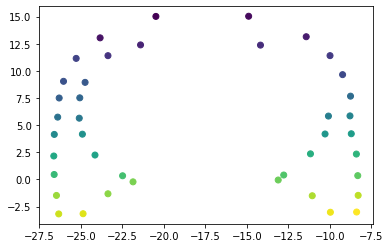

In [29]:
plt.scatter(marker_points[:, 0], -marker_points[:, 1], c=range(len(marker_points)))

In [35]:
draw_points_on_aruco(img, [res], marker_points, True)
cv2.waitKey(0)

[-4.15831482  3.98760244]


233

In [ ]:
import annotation_utils
def draw_bbox_by_points(img, 
                        res, 
                        points=annotation_utils.get_points_from_CAD(),
                        show=False):
    new_points = annotation_utils.get_keypoints_on_image(img, points, camera_params)
    top = new_points[:, 0].min()
    bottom = new_points[:, 0].max()
    left = new_points[:, 1].min()
    right = new_points[:, 1].max()
    bbox_corners = np.array([
        [top, left],
        [top, right],
        [bottom, right],
        [bottom, left],
    ])
    if show:
        imgc = img.copy()
        cv2.line(imgc, bbox_corners[0], bbox_corners[1], (0,255,0), 1)
        cv2.line(imgc, bbox_corners[1], bbox_corners[2], (0,255,0), 1)
        cv2.line(imgc, bbox_corners[2], bbox_corners[3], (0,255,0), 1)
        cv2.line(imgc, bbox_corners[3], bbox_corners[-1], (0,255,0), 1)
        cv2.imshow('draw_bbox_by_points', imgc)
        cv2.waitKey(0)
    return bbox_corners

In [ ]:
img = cv2.imread('/home/viacheslav/jupyter_notebooks/data/far_photos/20.jpg')
res = annotation_utils.detect_apriltag('/home/viacheslav/jupyter_notebooks/data/far_photos_with_marker/20.jpg', camera_params)
draw_bbox_by_points(img, res, show=True)

### get robot poses

In [19]:
inserted_j = ur10.getj()
inserted_l = ur10.getl()
print(inserted_j)
print(inserted_l)

[-4.998593632374899, -1.644775692616598, 1.8084745407104492, 6.020843982696533, -0.2982600370990198, 0.12933599948883057]
[0.10536873297868135, -0.5533021313854405, 0.5293912901803394, 1.242622745104883, 1.2236036661373513, 1.2353460642122878]


In [17]:
ur10.movel(zero_pose_l)

<Transform:
<Orientation: 
array([[-0.01692471,  0.02372329,  0.99957529],
       [ 0.99930341, -0.03285447,  0.01769985],
       [ 0.03326042,  0.99917856, -0.02315071]])>
<Vector: (0.60532, -0.55332, 0.52937)>
>

In [23]:
zero_pose_l = ur10.getl()
zero_pose_j = ur10.getj()
print(zero_pose_l)
print(zero_pose_j)

[0.6053518982089526, -0.553289395354214, 0.5294081583380398, 1.2425986747757027, 1.2235478703363973, 1.2352977113830281]
[-4.190050188695089, -1.1814973990069788, 1.6938786506652832, -3.591449562703268, -0.5103328863727015, 3.1160995960235596]


In [22]:
zero_pose_l = [0.6053738400708184,
 -0.5532917677103614,
 0.5293931050569378,
 1.242668373605403,
 1.2235408761040583,
 1.2353307425198223] # 15 cm from socket
ur10.movel(zero_pose_l)

<Transform:
<Orientation: 
array([[-0.01706775,  0.02374694,  0.9995723 ],
       [ 0.99929951, -0.03289479,  0.01784458],
       [ 0.03330447,  0.99917667, -0.02316886]])>
<Vector: (0.60534, -0.55326, 0.52940)>
>

In [24]:
ur10.movel([zero_pose_l[0]-0.5, *zero_pose_l[1:]], vel=1)
# ur10.movej([zero_pose_l[0]-0.5, *zero_pose_l[1:]], vel=1)

<Transform:
<Orientation: 
array([[-0.01703289,  0.02371058,  0.99957375],
       [ 0.99930309, -0.03280647,  0.01780647],
       [ 0.03321468,  0.99918044, -0.02313527]])>
<Vector: (0.10543, -0.55330, 0.52943)>
>

In [25]:
far_pose_l = ur10.getl()
far_pose_j = ur10.getj()
print(far_pose_l)
print(far_pose_l)

[0.10533391941557418, -0.5533141430155365, 0.5294019637203735, 1.2425500025074443, 1.2235740688727648, 1.2352615419888655]
[0.10533391941557418, -0.5533141430155365, 0.5294019637203735, 1.2425500025074443, 1.2235740688727648, 1.2352615419888655]


In [49]:
x_far = [0, .25]
y_far = [-.25, .25]
z_far = [-.2, .2]

In [33]:
x_close = [-.1, -.25]
y_close = [-.10, .10]
z_close = [-.15, .05]

In [56]:
ur10.movel([far_pose_l[0], far_pose_l[1]+y_far[0], far_pose_l[2]+z_far[1], 
            *far_pose_l[3:]], vel=1)

<Transform:
<Orientation: 
array([[-0.01701676,  0.02369183,  0.99957447],
       [ 0.99931074, -0.03258451,  0.01778459],
       [ 0.032992  ,  0.99918814, -0.02312102]])>
<Vector: (0.10529, -0.80325, 0.72944)>
>

In [38]:
ur10.movel(zero_pose_l)

<Transform:
<Orientation: 
array([[-0.01703297,  0.02372357,  0.99957344],
       [ 0.9993023 , -0.03282982,  0.01780752],
       [ 0.03323827,  0.99917936, -0.02314783]])>
<Vector: (0.60529, -0.55332, 0.52938)>
>

In [51]:
ur10.movel([zero_pose_l[0]+x_close[0], zero_pose_l[1]+y_close[0], zero_pose_l[2]+z_close[1], 
            *zero_pose_l[3:]], vel=1)

<Transform:
<Orientation: 
array([[-0.01698808,  0.02366321,  0.99957564],
       [ 0.99930719, -0.0327077 ,  0.01775781],
       [ 0.03311403,  0.9991848 , -0.02309118]])>
<Vector: (0.50529, -0.65325, 0.57944)>
>

In [27]:
R.from_rotvec([ 1.2186813991654113,
 1.2029606765250755,
 1.1943521654058413]).as_rotvec()

array([1.2186814 , 1.20296068, 1.19435217])

In [28]:
from scipy.spatial.transform import Rotation as R

# angles along X and Y
orients = np.array([
#         [-5, -5],
    [-5, 0],
#     [-5, 5],
#     [0,  -5],
    [0,  0],
#     [0,  5],
#     [5,  -5],
    [5,  0],
#     [5, 5]
], dtype=float)

# orients *= np.pi/180
rotations = [R.from_euler('xy', x, degrees=True) for x in orients]

In [29]:
r0 = rotations[0]
r0.as_matrix()

array([[ 1.        , -0.        ,  0.        ],
       [ 0.        ,  0.9961947 ,  0.08715574],
       [-0.        , -0.08715574,  0.9961947 ]])

In [30]:
r0.apply(lrc[3:])

array([1.21886184, 1.30249854, 1.0851754 ])

In [224]:
  img_coords = {}

In [225]:
img_coords

{}

In [237]:
ur10.movel(zero_pose)

<Transform:
<Orientation: 
array([[ 0.01497981,  0.00522241,  0.99987416],
       [ 0.99988605,  0.00179294, -0.01498936],
       [-0.00187099,  0.99998476, -0.00519496]])>
<Vector: (0.54892, -0.54403, 0.40710)>
>

In [219]:
llc

[0.5489486179287019,
 -0.4439867205295215,
 0.30719103192310093,
 1.218738328932778,
 1.2028588706030305,
 1.1943576930489765]

## Record points with aruco on socket

In [50]:
ur10.movel([far_pose_l[0]+x_far[0], far_pose_l[1]+y_far[0], far_pose_l[2]+z_far[1], 
            *far_pose_l[3:]])
#            , vel=1)
# ur10.movel(far_pose_l)

<Transform:
<Orientation: 
array([[-0.0170399 ,  0.02367616,  0.99957445],
       [ 0.99930489, -0.03274923,  0.01781101],
       [ 0.03315699,  0.99918313, -0.02310166]])>
<Vector: (0.10531, -0.80327, 0.72941)>
>

In [34]:
img_coords = [0]*2000
!rm data/points/*
!rm data/no_points/*

rm: cannot remove 'data/points/*': No such file or directory
rm: cannot remove 'data/no_points/*': No such file or directory


In [62]:
ur10.movel(lrf, vel=1., acc=1.)

<Transform:
<Orientation: 
array([[ 0.01476259,  0.00531222,  0.99987692],
       [ 0.99988992,  0.00140731, -0.01477026],
       [-0.0014856 ,  0.9999849 , -0.00529086]])>
<Vector: (0.44891, -0.64389, 0.30712)>
>

In [73]:
img_coords = [0]*600
# delta = .05
img_name = -1
js = []
# ur10.movel([far_pose_l[0]+x_far[0], far_pose_l[1]+y_far[0], far_pose_l[2]+z_far[0], 
#             *far_pose_l[3:]], vel=1)
pose = zero_pose_l.copy()
# i, j, k = 0,0,0
# these ranges for far
# xrange = [0, .05, .1, .15, .2, .25]
# yrange = [-.25, -.2, -.15, -.1, -.05, 0, .05, .1, .15, .2, .25]
# zrange = [-.2, -.15, -.1, -.05, 0, .05, .1, .15, .2] 

#these for close
xrange = [-.1, -.125, -.15, -.175, -.2, -.225, -.25]
yrange = [-.1, -.075, -.05, -.025, 0, .025, .05, .1, ]
zrange = [-.15, -.1, -.05, 0, .05,] 

from itertools import product
poss = list(product(*[xrange, yrange, zrange]))

for pos in poss:
#     print(pose, pos)
    ur10.movel([pose[0]+pos[0], pose[1]+pos[1], pose[2]+pos[2], *pose[3:]])
#             pose = [pose[0]+delta*i, pose[1]+delta*j, pose[2]+delta*k, *pose[3:]]
    img_name +=1
    img = get_photo_from_realsense()
    cv2.imshow('robot sees', img)
    cv2.waitKey(1)
    cv2.imwrite(
            f'/home/viacheslav/jupyter_notebooks/data/far_photos/{img_name}.jpg',
            img)
    js.append(ur10.getj())
            
json.dump(js, open(f'/home/viacheslav/jupyter_notebooks/data/far_photos_joints.json', 'w'))

In [95]:
ur10.movel(far_pose_l, vel=1)

<Transform:
<Orientation: 
array([[-0.01719527,  0.02371831,  0.99957079],
       [ 0.99930165, -0.0327621 ,  0.01796803],
       [ 0.03317421,  0.99918171, -0.02313839]])>
<Vector: (0.10537, -0.55328, 0.52940)>
>

In [ ]:
img_name = -1
for posej in tqdm(js):
    ur10.movej(posej)
    img_name +=1
    img = get_photo_from_realsense()
    cv2.imshow('robot sees', img)
    cv2.waitKey(1)
    cv2.imwrite(
            f'/home/viacheslav/jupyter_notebooks/data/far_photos_with_marker/{img_name}.jpg',
            img)

 82%|████████▏ | 486/594 [34:26<05:49,  3.24s/it]  

In [72]:
img_coords = [0]*600
delta = .05
img_name = -1
js = []
ur10.movel([far_pose_l[0]+x_far[0], far_pose_l[1]+y_far[0], far_pose_l[2]+z_far[0], 
            *far_pose_l[3:]], vel=1)
for i in range(6):
    for j in tqdm(range(11)):
        for k in range(7):
            for l in range(len(rotations)):
                pose = [lrf[0]+delta*i, lrf[1]+delta*j, lrf[2]+delta*k, *lrf[3:]]
                d_angle = orients[l]
                
                init_rotvec = lrc[3:]
                matrix = R.from_rotvec(init_rotvec).as_matrix()
                pose[3:] = R.from_matrix(rotations[l].apply(matrix)).as_rotvec()
                
                ur10.movel(pose, vel=1)
            
                img = get_photo_from_realsense()
                
                cv2.imwrite(
                    f'/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos_2/{img_name}.jpg',
                    img)

#                 res = detect_apriltag(img)

#                 if res: 
#                     img_w, desired_corners = warp_img(img, res)

#                     res_warp = detect_apriltag(img_w)
#                     if res_warp:
#                         img_name += 1
#                         center, points_w = draw_points_on_aruco(img_w, res_warp, seventeen_points, False)

#                         inv_project = get_projection(res[0].corners, desired_corners)
#                         img_ok = warp(img_w, inv_project)
#                         points = np.array([inv_project.params @ np.array([p[0], p[1], 1]) for p in points_w])
            
#                         center, points = draw_points_on_aruco(img, res, seventeen_points, True)

#                         img_coords[img_name] = points
#                         js.append(ur10.getj())
                
                        

# json.dump(img_coords, open(f'/home/viacheslav/jupyter_notebooks/data/seventeen_2.json', 'w'))
# json.dump(js, open(f'/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos_2.json', 'w'))

100%|██████████████████████████████████████████| 11/11 [40:43<00:00, 222.12s/it]


In [ ]:
img_name = -1
for posej in tqdm(js):
    ur10.movej(posej)
    img_name +=1
    img = get_photo_from_realsense()
    cv2.imshow('robot sees', img)
    cv2.waitKey(1)
    cv2.imwrite(
            f'/home/viacheslav/jupyter_notebooks/data/far_photos_with_marker/{img_name}.jpg',
            img)

In [ ]:
json.dump(img_coords, open(f'/home/viacheslav/jupyter_notebooks/data/seventeen_2.json', 'w'))
json.dump(js, open(f'/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos_2.json', 'w'))

In [60]:
img_coords = [0]*2000

for i, posej in enumerate(js):
    ur10.movej(posej, vel=1, acc=1)
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
            
    center, points = draw_points_on_aruco(img, res, seventeen_points, True)

    img_coords[i] = points
    
    
with open('img_coords.pickle', 'wb') as handle:
    pkl.dump(img_coords, handle, protocol=pkl.HIGHEST_PROTOCOL)

TypeError: 'NoneType' object is not subscriptable

In [69]:

with open('img_coords.pickle', 'wb') as handle:
    pkl.dump(img_coords, handle, protocol=pkl.HIGHEST_PROTOCOL)
    
# with open('js.pickle', 'wb') as handle:
#     pkl.dump(js, handle, protocol=pkl.HIGHEST_PROTOCOL)

Robot not running: {'size': 47, 'type': 0, 'timestamp': 39658016000, 'isPhysicalRobotConnected': True, 'isRealRobotEnabled': True, 'isPowerOnRobot': True, 'isEmergencyStopped': False, 'isSecurityStopped': False, 'isProgramRunning': False, 'isProgramPaused': False, 'robotMode': 4, 'controlMode': 0, 'speedFraction': 1.0, 'speedScaling': 0.0, 'speedFractionLimit': 63}
Robot not running: {'size': 47, 'type': 0, 'timestamp': 39658016000, 'isPhysicalRobotConnected': True, 'isRealRobotEnabled': True, 'isPowerOnRobot': True, 'isEmergencyStopped': False, 'isSecurityStopped': False, 'isProgramRunning': False, 'isProgramPaused': False, 'robotMode': 4, 'controlMode': 0, 'speedFraction': 1.0, 'speedScaling': 0.0, 'speedFractionLimit': 63}
Robot not running: {'size': 47, 'type': 0, 'timestamp': 39658016000, 'isPhysicalRobotConnected': True, 'isRealRobotEnabled': True, 'isPowerOnRobot': True, 'isEmergencyStopped': False, 'isSecurityStopped': False, 'isProgramRunning': False, 'isProgramPaused': False,

In [1]:

# approved by Viktor
def draw_points_on_aruco(img, res, changes=None, show=False):
    dx = (res[0].corners[2] - res[0].corners[1])/6
    dy = (res[0].corners[2] - res[0].corners[3])/6
    print (dx*dy)
    
    if changes is None:
        changes = np.array([
            [0, 0],
            [3, 1],
            [2, 2],
            [-2, 2],
            [-3, 1],
            [-3, -1],
            [-2, -3],
            [2, -3],
            [3, -1]
        ])
        
    points = np.zeros((changes.shape[0], 2), dtype=float)
    for i, ch in enumerate(changes):
        points[i] = [ch[0]*dx[0]+ch[1]*dy[0], ch[0]*dx[1]+ch[1]*dy[1]]
        
    points[:, 0] += sum([x[0] for x in res[0].corners])/4
    points[:, 1] += sum([x[1] for x in res[0].corners])/4
    
    if show:
#         draw_corners(img, res[0])
        for p in points:
            kp = int(p[0]), int(p[1])
            cv2.circle(img, kp, 2, (0, 0, 255), -1)
        cv2.imshow('draw_points_on_aruco', img)
        cv2.waitKey(1)
    return points[0], points[1:]

def warp_img(image, res):
    corners = res[0].corners
    
    corners[:2] = np.array(sorted(corners[:2], key=lambda x: x[1]))
    corners[2:] = np.array(sorted(corners[2:], key=lambda x: x[1]))

    a = corners[:2][:, 0].mean()
    c = corners[2:][:, 0].mean()
    b = corners[::2][:, 1].mean()
    d = corners[1::2][:, 1].mean()

    desired_corners = np.array([[a, b], [a, d], [c, b], [c, d]], dtype=int)

    tform = get_projection(desired_corners, corners)
    image_warped = warp(image, tform)
    return image_warped, desired_corners, tform

def draw_corners(img, r, show=False):
    if isinstance(r, np.ndarray):
        imagePoints = [r]
    else:
        imagePoints = r.corners.reshape(1,4,2)
    
    for corner in range(np.size(imagePoints[0],axis=0)):
        center = ((int(imagePoints[0][corner][0]),int(imagePoints[0][corner][1])))
        cv2.circle(img, center, 3, (0,0,255), -1)
    
    if show:
        cv2.imshow('img', color_image)
    return imagePoints[0]

In [62]:
cv2.destroyAllWindows()

In [159]:
cv2.destroyAllWindows()
# buf_sz = 10
# buffer = np.zeros((buf_sz, 17, 3), dtype=float)
# index = 0
while True:
    index += 1
    index = index % buf_sz
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    cv2.imshow('original', img)
    cv2.waitKey(1)
    if res: 
        img_w, desired_corners,tform = warp_img(img, res)
#         desired corners are int!
#         print("desired_corners",desired_corners)
        
        res_warp = detect_apriltag(img_w)
        if res_warp:
            center, points_w = draw_points_on_aruco(img_w, res_warp, seventeen_points, True)
#             corners_w = draw_corners(img_w, res_warp[0], False)
            inv_project = get_projection(res[0].corners, desired_corners)
#             print(inv_project)
            str_project = get_projection(desired_corners, res[0].corners)
            img_ok = warp(img_w, inv_project)
            
#             points = [np.linalg.inv(tform.params) @ np.array([p[0], p[1], 1]) for p in points_w]
            points = [str_project.params @ np.array([p[0], p[1], 1]) for p in points_w]

            for p in points:
                p/= p[2]
            points = np.array(points)
            
#             points = np.array([inv_project.params @ np.array([p[0], p[1], 1]) for p in points_w])
#             buffer[index] = points
#             corners = np.array([inv_project.params @ np.array([p[0], p[1], 1]) for p in corners_w])
#             print('corners', corners)
#             for p in np.mean(buffer, axis=0):
#                 kp = int(p[0]), int(p[1])
#                 cv2.circle(img_ok, kp, 2, (0,255, 255), -1)
            for c in points:
                kc = int(c[0]), int(c[1])
                cv2.circle(img, kc, 3, (0,255, 255), -1)
            cv2.imshow('final', img)
#             cv2.waitKey(10)
#             center, points = draw_points_on_aruco(img, res, seventeen_points, True)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to target thread (0x5609ee1c7dc0)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to target thread (0x5609ee1c7dc0)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to target thread (0x5609ee1c7dc0)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to target thread (0x5609ee1c7dc0)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to target thread (0x5609ee1c7dc0)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to target thread (0x5609ee1c7dc0)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to tar

[-0.79275909 -0.62291592]
[array([234.24072454, 280.7473101 ,   1.40128627]), array([359.53244105, 268.82268356,   1.46457768]), array([210.14961156, 361.31711852,   1.41632242]), array([304.11839895, 352.37364861,   1.46379098]), array([366.7642572 , 346.41133534,   1.49543668]), array([460.73304459, 337.46786544,   1.54290524]), array([165.29825112, 401.71366032,   1.40622218]), array([290.58996764, 389.78903378,   1.46951359]), array([415.88168416, 377.86440724,   1.532805  ]), array([541.17340067, 365.9397807 ,   1.59609641]), array([257.60160575, 453.14172794,   1.473777  ]), array([332.77663566, 445.98695201,   1.51175185]), array([426.74542305, 437.0434821 ,   1.55922041]), array([508.18503878, 429.29247485,   1.60035982]), array([397.3889839 , 481.98659934,   1.55904022]), array([330.11194324, 542.58141204,   1.54388987]), array([530.57868967, 523.50200957,   1.64515613])]


QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to target thread (0x5609ee1c7dc0)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to target thread (0x5609ee1c7dc0)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to target thread (0x5609ee1c7dc0)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to target thread (0x5609ee1c7dc0)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to target thread (0x5609ee1c7dc0)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to target thread (0x5609ee1c7dc0)

QObject::moveToThread: Current thread (0x5609ee1c7dc0) is not the object's thread (0x5609eea3da90).
Cannot move to tar

[-0.78665823 -0.66613569]
[array([233.81614739, 280.44611693,   1.39916994]), array([358.86842312, 268.38474246,   1.46203436]), array([209.7573564 , 360.94231739,   1.4142621 ]), array([303.54656319, 351.89628654,   1.46141041]), array([366.07270106, 345.86559931,   1.49284263]), array([459.86190785, 336.81956846,   1.53999095]), array([164.98537863, 401.34170304,   1.40430267]), array([290.03765435, 389.28032857,   1.46716709]), array([415.08993008, 377.2189541 ,   1.53003152]), array([540.14220581, 365.15757963,   1.59289594]), array([257.10178331, 452.59217982,   1.47152286]), array([332.13314875, 445.35535514,   1.50924151]), array([425.92235555, 436.30932429,   1.55638983]), array([507.20633477, 428.46943089,   1.59725171]), array([396.61463203, 481.23068889,   1.55629565]), array([329.45666538, 541.82976736,   1.54135651]), array([529.54030654, 522.53156821,   1.64193959])]
[ 0.01988342 -0.67256768]
[array([234.44469136, 281.61244251,   1.40411461]), array([360.09349833, 269.705

[ 0.11053723 -0.64784867]
[array([233.91425125, 280.70721491,   1.40071547]), array([359.13607662, 268.81365249,   1.46405341]), array([209.89404469, 361.19191882,   1.4156606 ]), array([303.81041372, 352.27174701,   1.46316405]), array([366.4213264 , 346.3249658 ,   1.49483302]), array([460.33769543, 337.40479398,   1.54233647]), array([165.09422714, 401.5408182 ,   1.40550583]), array([290.31605251, 389.64725578,   1.46884376]), array([415.53787787, 377.75369336,   1.5321817 ]), array([540.75970324, 365.86013094,   1.59551964]), array([257.39029838, 452.9309006 ,   1.47303179]), array([332.5233936 , 445.79476315,   1.51103455]), array([426.43976262, 436.87459133,   1.55853801]), array([507.83394911, 429.14377576,   1.59970767]), array([397.13064346, 481.76782083,   1.55830273]), array([329.93091714, 542.2911699 ,   1.54307057]), array([530.28583772, 523.26147002,   1.64441127])]
[-0.91157656 -0.69134148]
[array([233.88483614, 280.38496831,   1.39907221]), array([358.87260203, 268.390

[-0.32958121 -0.60608128]
[array([234.61765587, 281.32520778,   1.40409735]), array([360.30796069, 269.41203288,   1.46778791]), array([210.52402532, 362.15592126,   1.41935247]), array([304.79175394, 353.22104009,   1.4671204 ]), array([367.63690635, 347.26445263,   1.49896568]), array([461.90463496, 338.32957146,   1.5467336 ]), array([165.56419069, 402.66979765,   1.40924584]), array([291.25449551, 390.75662275,   1.4729364 ]), array([416.94480033, 378.84344784,   1.53662697]), array([542.63510515, 366.93027294,   1.60031753]), array([258.21820607, 454.30869176,   1.4773222 ]), array([333.63238896, 447.16078682,   1.51553654]), array([427.90011758, 438.22590564,   1.56330447]), array([509.59881571, 430.48234195,   1.60470333]), array([398.49019973, 483.3080127 ,   1.56319   ]), array([331.05044779, 544.07882728,   1.54803005]), array([532.1549355 , 525.01774743,   1.64993495])]
[-0.5593591  -0.76126854]
[array([233.20995775, 279.85983603,   1.39574882]), array([357.79319833, 267.619

[-0.851837   -0.64025258]
[array([233.33561418, 279.86772594,   1.39576501]), array([357.87092556, 267.66312044,   1.45789137]), array([209.3535675 , 360.15948755,   1.4109151 ]), array([302.75505103, 351.00603343,   1.45750987]), array([365.02270672, 344.90373068,   1.48857305]), array([458.42419025, 335.75027656,   1.53516781]), array([164.75619289, 400.503079  ,   1.40118113]), array([289.29150426, 388.29847351,   1.46330748]), array([413.82681564, 376.09386801,   1.52543384]), array([538.36212701, 363.88926252,   1.58756019]), array([256.47431704, 451.46959077,   1.46779297]), array([331.19550386, 444.14682747,   1.50506878]), array([424.59698739, 434.99337335,   1.55166355]), array([505.54493979, 427.06037978,   1.59204568]), array([395.39819077, 479.8233857 ,   1.55169707]), array([328.50212885, 540.33877288,   1.53709611]), array([527.75862705, 520.81140409,   1.63649828])]
[-0.81521151 -0.91041799]
[array([233.68918946, 280.07936254,   1.39745309]), array([358.4553607 , 268.044

[array([233.97711736, 280.55306978,   1.40000089]), array([359.09677444, 268.54223242,   1.46292993]), array([209.95362949, 361.13332726,   1.41521515]), array([303.7933723 , 352.12519925,   1.46241193]), array([366.35320084, 346.11978057,   1.49387646]), array([460.19294365, 337.11165255,   1.54107324]), array([165.17980433, 401.55790231,   1.40529468]), array([290.29946141, 389.54706496,   1.46822373]), array([415.4191185 , 377.5362276 ,   1.53115277]), array([540.53877558, 365.52539025,   1.59408181]), array([257.38297185, 452.91774425,   1.47266596]), array([332.4547661 , 445.71124184,   1.51042339]), array([426.29450891, 436.70311383,   1.55762017]), array([507.62228601, 428.89606955,   1.59852405]), array([396.99698336, 481.6631312 ,   1.55758328]), array([329.83624563, 542.29999378,   1.54270258]), array([530.02769696, 523.08265401,   1.64338905])]
[-0.80024514 -0.65938014]
[array([233.58992151, 280.11364312,   1.39746696]), array([358.49002051, 268.04176518,   1.46018188]), arr

[array([235.24974051, 282.39691391,   1.409313  ]), array([361.81950182, 270.51861134,   1.47376776]), array([211.05292878, 363.70089001,   1.42493766]), array([305.98024976, 354.79216308,   1.47327872]), array([369.26513042, 348.8530118 ,   1.5055061 ]), array([464.1924514 , 339.94428487,   1.55384716]), array([165.80869533, 404.42380659,   1.41479583]), array([292.37845663, 392.54550402,   1.47925058]), array([418.94821794, 380.66720146,   1.54370534]), array([545.51797925, 368.78889889,   1.60816009]), array([259.16132131, 456.45759747,   1.48383246]), array([335.1031781 , 449.33061593,   1.52250531]), array([430.03049908, 440.42188901,   1.57084638]), array([512.30084393, 432.70099234,   1.61274197]), array([400.45001628, 485.75426955,   1.57083096]), array([332.5836661 , 546.83864442,   1.55561822]), array([535.09528419, 527.83336031,   1.65874583])]
[-0.2061928  -0.66517363]
[array([233.75785782, 280.62264321,   1.39990364]), array([358.86149831, 268.74178427,   1.46318351]), arr

[array([233.88919527, 280.54903323,   1.39948245]), array([358.85882854, 268.44298844,   1.46211211]), array([209.948687  , 361.14679791,   1.41491506]), array([303.67591195, 352.06726432,   1.46188731]), array([366.16072859, 346.01424192,   1.49320214]), array([459.88795354, 336.93470834,   1.54017439]), array([165.25355114, 401.60508597,   1.40517597]), array([290.22318442, 389.49904118,   1.46780564]), array([415.19281769, 377.3929964 ,   1.5304353 ]), array([540.16245096, 365.28695162,   1.59306496]), array([257.38783575, 452.89417303,   1.47245038]), array([332.36961571, 445.63054616,   1.51002817]), array([426.09684067, 436.55101257,   1.55700042]), array([507.32710229, 428.68208346,   1.5977097 ]), array([396.86361494, 481.5329071 ,   1.55712026]), array([329.82091116, 542.22033919,   1.54251162]), array([529.77232439, 522.85066754,   1.64271908])]
[-0.42129123 -0.70178069]
[array([232.49089948, 279.02981391,   1.39126124]), array([356.52181184, 266.96173568,   1.4533147 ]), arr

[-0.7608697  -0.77415759]
[array([233.58022879, 280.14790371,   1.39740183]), array([358.2375858 , 267.97393207,   1.45966576]), array([209.66177141, 360.57961492,   1.41271719]), array([303.15478917, 351.44913619,   1.45941514]), array([365.48346767, 345.36215036,   1.49054711]), array([458.97648543, 336.23167163,   1.53724506]), array([165.06088727, 400.97955092,   1.40302245]), array([289.71824428, 388.80557927,   1.46528639]), array([414.37560129, 376.63160763,   1.52755032]), array([539.03295831, 364.45763599,   1.58981425]), array([256.93588972, 452.08081539,   1.46988313]), array([331.73030393, 444.77643241,   1.50724149]), array([425.22332168, 435.64595367,   1.55393944]), array([506.25060374, 427.73287211,   1.594411  ]), array([396.04280564, 480.54731754,   1.55404397]), array([329.14147943, 541.14722154,   1.53950186]), array([528.59325065, 521.66886691,   1.63912415])]
[-0.88918815 -0.64889704]
[array([233.50095653, 280.03698901,   1.39682966]), array([358.08123762, 267.874

[array([234.65512217, 281.50547304,   1.4048546 ]), array([360.56807811, 269.59292005,   1.46867374]), array([210.50476606, 362.4042862 ,   1.42017505]), array([304.93948301, 353.46987145,   1.4680394 ]), array([367.89596098, 347.51359496,   1.49994896]), array([462.33067794, 338.57918022,   1.54781332]), array([165.45880587, 402.94942577,   1.41006395]), array([291.37176181, 391.03687278,   1.47388308]), array([417.28471775, 379.12431979,   1.53770222]), array([543.19767369, 367.21176679,   1.60152135]), array([258.26614681, 454.6412544 ,   1.47830429]), array([333.81392037, 447.4937226 ,   1.51659577]), array([428.24863733, 438.55930786,   1.56446012]), array([510.09205869, 430.81614841,   1.60594256]), array([398.77905903, 483.67800264,   1.56436401]), array([331.21011875, 544.495712  ,   1.54919736]), array([532.67084825, 525.43562721,   1.65130798])]
[-0.91808788 -0.53560528]
[array([234.06856463, 280.51128444,   1.40017868]), array([359.29990408, 268.67868391,   1.46366905]), arr

[-0.7338377  -0.56525484]
[array([234.21240391, 280.66762481,   1.40121407]), array([359.64404239, 268.9414278 ,   1.465134  ]), array([209.98845334, 361.088725  ,   1.41561825]), array([304.06218221, 352.29407724,   1.4635582 ]), array([366.77800145, 346.43097873,   1.49551816]), array([460.85173031, 337.63633098,   1.5434581 ]), array([165.03811195, 401.36320889,   1.40505713]), array([290.46975043, 389.63701188,   1.46897705]), array([415.90138892, 377.91081487,   1.53289698]), array([541.3330274 , 366.18461786,   1.5968169 ]), array([257.36306094, 452.85241937,   1.47268182]), array([332.62204403, 445.81670116,   1.51103377]), array([426.69577289, 437.0220534 ,   1.55897372]), array([508.22633791, 429.40002535,   1.60052167]), array([397.24950832, 481.8591485 ,   1.55837105]), array([329.82399624, 542.27087434,   1.54252936]), array([530.51461781, 523.50895912,   1.64480124])]
[-0.97752263 -0.69584861]
[array([233.28527358, 279.66959286,   1.39520981]), array([357.72795939, 267.579

[array([234.35889597, 281.26974777,   1.40280801]), array([359.87336816, 269.52629395,   1.46676703]), array([210.19246479, 361.69303096,   1.41740944]), array([304.32831893, 352.88544059,   1.4653787 ]), array([367.08555502, 347.01371369,   1.49735821]), array([461.22140916, 338.20612332,   1.54532748]), array([165.24636943, 401.97316846,   1.40692883]), array([290.76084161, 390.22971464,   1.47088785]), array([416.2753138 , 378.48626082,   1.53484687]), array([541.78978598, 366.742807  ,   1.59880588]), array([257.68884007, 453.44879254,   1.47473983]), array([332.99752338, 446.40272024,   1.51311524]), array([427.13337752, 437.59512988,   1.56108451]), array([508.71778444, 429.9618849 ,   1.60265787]), array([397.70725283, 482.4356571 ,   1.56058294]), array([330.28810978, 542.85586335,   1.54486202]), array([531.11126527, 524.06633724,   1.64719646])]
[-1.02723197 -0.60437787]
[array([233.95847341, 280.43189645,   1.39962486]), array([359.01054613, 268.47958034,   1.46266327]), arr

[array([234.18106735, 281.17682226,   1.4020305 ]), array([359.56147431, 269.28631409,   1.46548884]), array([210.10629687, 361.66709066,   1.41701219]), array([304.14160209, 352.74920953,   1.46460594]), array([366.83180557, 346.80395545,   1.49633511]), array([460.86711079, 337.88607433,   1.54392886]), array([165.23860093, 402.01773596,   1.40684187]), array([290.61900789, 390.1272278 ,   1.47030021]), array([415.99941485, 378.23671963,   1.53375855]), array([541.3798218 , 366.34621147,   1.59721689]), array([257.63298364, 453.41480058,   1.47450247]), array([332.86122782, 446.28049569,   1.51257747]), array([426.89653303, 437.36261456,   1.56017122]), array([508.39379756, 429.63378426,   1.60141914]), array([397.53729571, 482.25844092,   1.55993989]), array([330.2357518 , 542.78440888,   1.54468441]), array([530.84440293, 523.75959582,   1.64621776])]
[-0.50258067 -0.61913336]
[array([233.86280286, 280.5897728 ,   1.39909418]), array([358.82791647, 268.73706065,   1.46237718]), arr

[ 0.13849001 -0.67506331]
[array([234.12025099, 281.27869599,   1.40214495]), array([359.57326601, 269.3291129 ,   1.46556335]), array([210.05323097, 361.80729862,   1.41723386]), array([304.14299224, 352.84511131,   1.46479766]), array([366.86949974, 346.87031976,   1.49650686]), array([460.95926101, 337.90813245,   1.54407066]), array([165.16956384, 402.19154144,   1.40712378]), array([290.62257886, 390.24195835,   1.47054218]), array([416.07559388, 378.29237526,   1.53396058]), array([541.5286089 , 366.34279217,   1.59737898]), array([257.63413866, 453.56583535,   1.47483152]), array([332.90594767, 446.3960855 ,   1.51288256]), array([426.99570893, 437.43389818,   1.56044636]), array([508.54016869, 429.66666917,   1.60166832]), array([397.63115003, 482.35809124,   1.56027798]), array([330.30564934, 542.93445546,   1.54511287]), array([531.03047337, 523.81512252,   1.64658231])]
[-1.14454483 -0.69957198]
[array([233.64116917, 279.93171937,   1.39699177]), array([358.36081826, 268.047

[-1.09607246 -0.66086339]
[array([233.87238264, 280.29613121,   1.39879339]), array([358.85356943, 268.36343928,   1.46194426]), array([209.74520378, 360.6302049 ,   1.41343976]), array([303.48109388, 351.68068596,   1.46080291]), array([365.97168728, 345.71433999,   1.49237834]), array([459.70757737, 336.76482104,   1.5397415 ]), array([164.96080171, 400.92011751,   1.40319746]), array([289.94198851, 388.98742558,   1.46634833]), array([414.9231753 , 377.05473365,   1.5294992 ]), array([539.90436209, 365.12204172,   1.59265007]), array([256.96171399, 452.15971595,   1.47032812]), array([331.95042606, 445.00010079,   1.50821865]), array([425.68631616, 436.05058185,   1.5555818 ]), array([506.92408757, 428.29433209,   1.59662986]), array([396.35106465, 480.8678197 ,   1.55521011]), array([329.17446155, 541.30268862,   1.53984667]), array([529.14436042, 522.21038153,   1.64088806])]
[-1.15410911 -0.50992025]
[array([234.34746355, 280.77609846,   1.4016559 ]), array([359.72324589, 268.977

[array([233.94094708, 280.72156492,   1.40057197]), array([359.1707351 , 268.61087299,   1.46342057]), array([209.94394047, 361.41597219,   1.41603642]), array([303.86628149, 352.33295324,   1.46317286]), array([366.4811755 , 346.27760727,   1.49459716]), array([460.40351652, 337.19458831,   1.54173361]), array([165.1526868 , 401.92011568,   1.40625308]), array([290.38247482, 389.80942374,   1.46910167]), array([415.61226285, 377.6987318 ,   1.53195027]), array([540.84205087, 365.58803987,   1.59479886]), array([257.47364804, 453.27943225,   1.47374564]), array([332.61152086, 446.01301708,   1.5114548 ]), array([426.53386188, 436.92999813,   1.55859124]), array([507.93322409, 429.05804837,   1.59944283]), array([397.23619373, 481.96453868,   1.55869959]), array([330.04931322, 542.72075392,   1.54402458]), array([530.41697406, 523.34364682,   1.64458233])]
[-0.43315041 -0.69272442]
[array([235.21911258, 282.1254524 ,   1.40838266]), array([361.45226137, 270.19948284,   1.47246717]), arr

[array([233.93590534, 280.76550974,   1.40106487]), array([359.16695244, 268.8674554 ,   1.46441972]), array([209.93343535, 361.27739883,   1.41604206]), array([303.85672068, 352.35385807,   1.4635582 ]), array([366.47224423, 346.4048309 ,   1.49523563]), array([460.39552956, 337.48129015,   1.54275177]), array([165.13932113, 401.64005458,   1.40589754]), array([290.37036824, 389.74200024,   1.46925239]), array([415.60141534, 377.8439459 ,   1.53260724]), array([540.83246245, 365.94589156,   1.5959621 ]), array([257.45719358, 453.04707504,   1.47346313]), array([332.59582184, 445.90824244,   1.51147604]), array([426.51910717, 436.98470168,   1.55899219]), array([507.91928779, 429.25096636,   1.60017284]), array([397.21833256, 481.89315676,   1.55877196]), array([330.02716123, 542.43714039,   1.54355517]), array([530.3968366 , 523.40025344,   1.64492294])]
[-1.06392056 -0.71431594]
[array([234.43656777, 280.95845644,   1.40256258]), array([359.92206057, 269.14068277,   1.46625309]), arr

KeyboardInterrupt: 

In [140]:
for p in points:
    p/= p[2]

In [146]:
points

array([[462.22914143, 344.60882207,   1.        ],
       [528.15109782, 346.39019828,   1.        ],
       [429.39054877, 378.46724671,   1.        ],
       [478.09929266, 380.64639654,   1.        ],
       [511.93851665, 382.16030827,   1.        ],
       [564.88907891, 384.52923014,   1.        ],
       [397.1614975 , 393.41963969,   1.        ],
       [461.2930526 , 396.83381014,   1.        ],
       [529.83536447, 400.48279597,   1.        ],
       [603.25967429, 404.39168464,   1.        ],
       [427.51933496, 423.72962432,   1.        ],
       [467.55663242, 426.44739989,   1.        ],
       [519.96445751, 430.00490041,   1.        ],
       [567.65852024, 433.24242558,   1.        ],
       [491.75763153, 449.59213358,   1.        ],
       [439.12419437, 473.33038589,   1.        ],
       [555.1582764 , 484.08053865,   1.        ]])

In [157]:
tform

<ProjectiveTransform(matrix=
    [[ 1.91992493e+00,  3.39838545e-01, -2.59333894e+02],
     [ 2.22398239e-01,  1.78964999e+00, -1.65473360e+02],
     [ 7.53614605e-04,  7.39015012e-04,  1.00000000e+00]]) at 0x7f260eda8e50>

In [53]:
# with open('img_coords.pickle', 'rb') as file:
#     file.seek(0)
#     img_coords = pkl.load(file)
    
with open('js.pickle', 'rb') as handle:
    js = pkl.load(handle)

## Save data

In [57]:
json.dump(img_coords, open(f'/home/viacheslav/jupyter_notebooks/data/seventeen.json', 'w'))
json.dump(js, open(f'/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos.json', 'w'))

## Get photos

In [67]:
coords_j = json.load(open('/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos.json'))
print('data len', len(coords_j))
for i, position in tqdm(enumerate(coords_j)):
    ur10.movej(position, vel=1, acc=1)
    img = get_photo_from_realsense()
    cv2.imwrite(f'/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos_17/{i}.png', img)

483it [08:53,  1.10s/it]


In [235]:
json.dump( img_coords, open(f'/home/viacheslav/jupyter_notebooks/data/seventeen.json', 'w'))

In [58]:
ur10.movej([-4.250930611287252, -0.8361623922931116, 1.6090149879455566, 2.2111873626708984, -0.48303395906557256, 3.2748172283172607],)

[-4.250751320515768,
 -0.8363898436175745,
 1.6091465950012207,
 2.211355209350586,
 -0.4832256476031702,
 3.274637460708618]

In [294]:

llc_points = []
lrc_points = []
for _ in range(10):
    ur10.movel(llc)
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    center, points = draw_points_on_aruco(img, res, seventeen_points, True)
    lrc_points.append(points)
    ur10.movel(lrc)
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    center, points = draw_points_on_aruco(img, res, seventeen_points, True)
    llc_points.append(points)

In [70]:
points

[[141.2156620025635, 31.427259445190458],
 [235.98294258117676, 30.749380111694364],
 [94.27264328002933, 93.3649314880371],
 [165.34810371398927, 92.85652198791504],
 [212.7317440032959, 92.517582321167],
 [283.80720443725585, 92.00917282104494],
 [47.09236679077151, 122.13405532836914],
 [141.8596473693848, 121.45617599487306],
 [236.62692794799804, 120.77829666137698],
 [331.3942085266113, 120.1004173278809],
 [94.8149467468262, 169.17875595092772],
 [151.67531509399416, 168.77202835083008],
 [222.7507755279541, 168.26361885070804],
 [284.3495079040527, 167.82299728393556],
 [185.08112106323244, 201.70331878662105],
 [114.31070632934569, 244.85700454711912],
 [265.9383552551269, 243.77239761352536]]

In [197]:
cv2.destroyAllWindows()

In [ ]:

points = json.load(open('/home/viacheslav/jupyter_notebooks/data/seventeen.json'))
# cv2.imshow('img', img)
# cv2.waitKey(0)
for i in range(len(points)): 
    img = cv2.imread(f'/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos_17/{i}.png')    
    draw_points(img, points[i], True, True)

In [19]:
pose = ur10.getj()

In [57]:
ur10.movej(pose)

[-4.138930384312765,
 -1.0015667120562952,
 1.7134833335876465,
 -3.7953017393695276,
 -0.5600474516498011,
 3.1207034587860107]

# Robot sees

In [9]:
# ur10.movel((lrf+llf)/2, vel=1)

# for i in range(100):
i = 0
while True:
    i +=1
    img = get_photo_from_realsense()
    cv2.imshow('robot_sees', img)
    cv2.waitKey(1)
#     cv2.imwrite(f'/home/viacheslav/jupyter_notebooks/data/video/{i}.jpg', img)

KeyboardInterrupt: 

In [10]:
cv2.imwrite(f'/home/viacheslav/jupyter_notebooks/data/no_marker_close_new_4.jpg', img)

True

In [ ]:
cv2.imshow('anchors', cv2.imread('/home/viacheslav/jupyter_notebooks/no_marker_with_points_with_anchors.png'))
cv2.waitKey(0)

QObject::moveToThread: Current thread (0x55b729b48190) is not the object's thread (0x55b729c6e3a0).
Cannot move to target thread (0x55b729b48190)

QObject::moveToThread: Current thread (0x55b729b48190) is not the object's thread (0x55b729c6e3a0).
Cannot move to target thread (0x55b729b48190)

QObject::moveToThread: Current thread (0x55b729b48190) is not the object's thread (0x55b729c6e3a0).
Cannot move to target thread (0x55b729b48190)

QObject::moveToThread: Current thread (0x55b729b48190) is not the object's thread (0x55b729c6e3a0).
Cannot move to target thread (0x55b729b48190)

QObject::moveToThread: Current thread (0x55b729b48190) is not the object's thread (0x55b729c6e3a0).
Cannot move to target thread (0x55b729b48190)

QObject::moveToThread: Current thread (0x55b729b48190) is not the object's thread (0x55b729c6e3a0).
Cannot move to target thread (0x55b729b48190)

QObject::moveToThread: Current thread (0x55b729b48190) is not the object's thread (0x55b729c6e3a0).
Cannot move to tar

In [34]:
def detect_blue_pixels(path:str, img:np.array=None):
    red_pixel =  np.array([255,0,0])
#     up=220
#     low=40
    if img is None:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    indices = []
    for x, row in enumerate(img):
        for y, cell in enumerate(row):
            if np.array_equal(img[x, y], red_pixel):
#             if img[x, y,0] > up and img[x,y,1] < low and img[x,y,2] < low:
                indices.append((y,x))
#     assert len(indices) == 17, f'wrong keypoint number!! {indices}'
    return indices

In [36]:
# detect_blue_pixels('/home/viacheslav/jupyter_notebooks/no_marker_with_points_with_anchors.png')
# cv2.imshow()
detect_blue_pixels('/home/viacheslav/jupyter_notebooks/data/marked_image.jpg')

[]

In [193]:
get_projection(res[0].corners, desired_corners)

<ProjectiveTransform(matrix=
    [[ 3.44026593e-01, -6.36294255e-01,  3.26868388e+02],
     [ 2.30746570e-01,  3.33694772e-01, -7.74937751e+00],
     [-2.99039459e-04, -5.81251796e-04,  1.00000000e+00]]) at 0x7fc7150d1700>

In [95]:
 ur10.movel((lrf+llf)/2, vel=1)


<Transform:
<Orientation: 
array([[ 0.01491866,  0.00527779,  0.99987478],
       [ 0.99988688,  0.00183326, -0.01492852],
       [-0.00191182,  0.99998439, -0.00524985]])>
<Vector: (0.44896, -0.54394, 0.30718)>
>

## Get nice graphs

In [254]:
import pandas as pd

In [295]:
len(llc_points), llc_points[0].shape

df_res = pd.DataFrame([])
n_obs = len(llc_points)

for obs in range(n_obs):
    df_loc = pd.DataFrame(llc_points[obs], columns = ['x', 'y'])
    
    len_df_loc = len(df_loc)
    df_loc['N_keypoint'] = list(range(len_df_loc))
    df_loc['N_obs'] = [obs] * len_df_loc
    
    # Костыль 17 точка
    df_loc_17 = pd.DataFrame([[df_loc.x.mean(), df_loc.y.mean(), 16, obs]], columns=['x', 'y', 'N_keypoint', 'N_obs'])
    df_loc = pd.concat([df_loc, df_loc_17])
    
    # уже не костыль
    df_res = pd.concat([df_res, df_loc])
    
    
df_res

,x,y,N_keypoint,N_obs
0,324.482481,53.202858,0,0
1,217.794164,100.719398,1,0
2,271.372712,100.178499,2,0
3,307.091744,99.817900,3,0
4,360.670293,99.277000,4,0
...,...,...,...,...
12,361.072942,156.704655,12,9
13,286.261277,182.451223,13,9
14,232.963120,215.137717,14,9
15,347.331833,214.027757,15,9


In [297]:
df_mean = df_res.groupby('N_keypoint').mean()[['x', "y"]]
df_res['x_mean'] = df_res['N_keypoint'].map(df_mean['x'])
df_res['y_mean'] = df_res['N_keypoint'].map(df_mean['y'])

df_res['x_error'] = (df_res['x'] - df_res['x_mean'])
df_res['y_error'] = (df_res['y'] - df_res['y_mean'])

df_res['x_error_sqr'] = df_res['x_error'] ** 2
df_res['y_error_sqr'] = df_res['y_error'] ** 2

df_res['x_error_abs'] = abs(df_res['x_error'])
df_res['y_error_abs'] = abs(df_res['y_error'])

df_res['euclid_dist'] = np.sqrt(df_res['x_error']**2 + df_res['y_error']**2)

<AxesSubplot:xlabel='N_keypoint', ylabel='euclid_dist'>

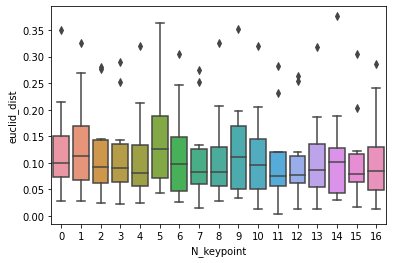

In [299]:
import seaborn as sns

sns.boxplot(data=df_res, x='N_keypoint', y='euclid_dist')

<AxesSubplot:xlabel='N_keypoint', ylabel='y_error_sqr'>

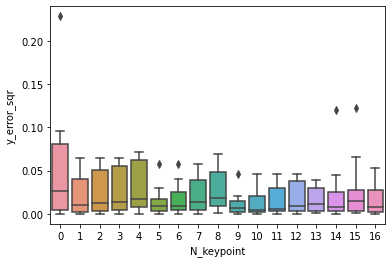

In [293]:
sns.boxplot(data=df_res, x='N_keypoint', y='y_error_sqr')

<AxesSubplot:xlabel='N_keypoint', ylabel='x_error_abs'>

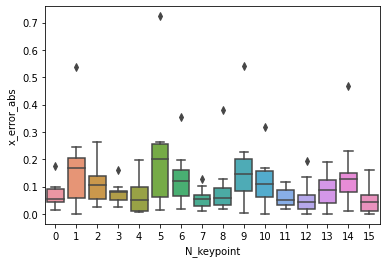

In [284]:
sns.boxplot(data=df_res, x='N_keypoint', y='x_error_abs')

In [ ]:
np.sqrt(np.var(llc_points, axis=0))

In [ ]:
llc_points

In [ ]:
plt.boxplot(np.sqrt(np.var(llc_points, axis=2)))

In [198]:
while True:
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    if not res:
        continue
    
    center, points = draw_points_on_aruco(img, res, seventeen_points,True)

KeyboardInterrupt: 

In [ ]:
poses = {}
while True:
#     next_pos = [np.random.uniform(min_x, max_x),
#                 np.random.uniform(min_y, max_y),
#                 np.random.uniform(min_z, max_z),
#                 np.random.uniform(min_rx, max_rx),
#                 np.random.uniform(min_ry, max_ry),
#                 np.random.uniform(min_rz, max_rz)]
#     ur10.movel(next_pos)
   
#     pose = tuple(ur10.getj())
    
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    if not res:
        continue
    
    center, points = draw_points_on_aruco(img, res, True)
#     poses[pose] = points
    

In [ ]:
poses

In [203]:
cv2.destroyAllWindows()

# Record points

In [ ]:
points = []
name = 0
path = '/home/viacheslav/jupyter_notebooks/results1/'

while True:
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    if not res: 
        continue 
    draw_apriltag(img, res)
    tvec, rvec = solve_pnp(res)
    processed, projected_points = get_socket_points(img, points_arr, lines, bbox, tvec, rvec, 
                                   show=True, draw_l=False, draw_p=False, draw_b=False)
    
    fname = path + str(name) + '.jpg'
    points.append((name, projected_points))
    cv2.imwrite(fname, processed)
    name += 1
#     break


In [ ]:
import json

with open(path + 'points.json', 'w') as f:
    json.dump(points, f)

In [164]:
img = get_photo_from_realsense()
cv2.imwrite('/home/viacheslav/jupyter_notebooks/no_marker.jpg', img)

True

Robot not running: {'size': 47, 'type': 0, 'timestamp': 35114256000, 'isPhysicalRobotConnected': True, 'isRealRobotEnabled': True, 'isPowerOnRobot': True, 'isEmergencyStopped': False, 'isSecurityStopped': False, 'isProgramRunning': False, 'isProgramPaused': False, 'robotMode': 4, 'controlMode': 0, 'speedFraction': 0.41, 'speedScaling': 0.0, 'speedFractionLimit': 63}
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/viacheslav/anaconda3/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/home/viacheslav/anaconda3/lib/python3.9/site-packages/urx/ursecmon.py", line 291, in run
    data = self._get_data()
  File "/home/viacheslav/anaconda3/lib/python3.9/site-packages/urx/ursecmon.py", line 338, in _get_data
    tmp = self._s_secondary.recv(1024)
socket.timeout: timed out
